In [1]:
from pathlib import Path
from typing import List
from pandas import DataFrame, read_json
import matplotlib.pyplot as plt
from pandas import set_option

set_option('display.max_rows', None)

In [2]:
def list_result_files() -> List[Path]:
    cwd = Path.cwd().resolve()
    for base in [cwd] + list(cwd.parents):
        candidate = base / "experiments/results/sepsis_event_log"
        if candidate.is_dir():
            return sorted(candidate.glob("*.jsonl"))
    raise FileNotFoundError(
        "Could not locate results directory."
    )
def load_fulfillment_results_dataframe(result_file: Path) -> DataFrame:
    print(f"Loading file: {result_file.name}")
    with open(result_file, 'r') as f:
        return read_json(f, lines=True)


In [3]:
def plot_fulfillment_diff_histogram(df: DataFrame, column: str = "diff", bins: int = 20) -> None:
    plt.figure(figsize=(8,5))
    counts, bins_edges, patches = plt.hist(df[column], bins=bins, color='teal', edgecolor='black', alpha=0.7)
    plt.axvline(x=0.0, color='#FF0000', linestyle='--', linewidth=3, label='Zero Difference')
    plt.text(0.02, max(counts)*0.9, ' ', color='#FF0000', fontsize=10, weight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.title("Histogram of Fulfillment Ratio Differences", fontsize=14, weight='bold', pad=20)
    plt.xlabel("Difference in Fulfillment Ratio (Control-Flow − Data-Aware)", fontsize=11, labelpad=15)
    plt.ylabel("Number of Constraints", fontsize=11, labelpad=15)
    plt.tight_layout()
    plt.show()


In [4]:
def analyze_sepsis_constraints(df: DataFrame, min_fulfilment_ratio: float = 0.0):
    mask_ratio = df["Fulfilment Ratio Data"] > min_fulfilment_ratio
    df_filtered = df[mask_ratio]

    idx_max = df_filtered.groupby("Constraint")["# Activations No Data"].idxmax()
    df_analyzed = df_filtered.loc[idx_max].reset_index(drop=True)

    df_analyzed["diff"] = (
            df_analyzed["Fulfilment Ratio No Data"] - df_analyzed["Fulfilment Ratio Data"]
    )

    total = len(df_analyzed)
    more_no_data = (df_analyzed["diff"] > 0).sum()
    more_data = (df_analyzed["diff"] < 0).sum()
    ties = (df_analyzed["diff"] == 0).sum()

    print(f"Total constraints discovered: {total}")
    print(f"Constraints with higher fulfilment under No Data: {more_no_data}")
    print(f"Constraints with higher fulfilment under Data: {more_data}")
    print(f"Ties (equal fulfilment): {ties}\n")

    print("Descriptive statistics for diff (No Data - Data):")
    print(df_analyzed["diff"].describe())

    return df_analyzed, df


---
# _**Lossy Counting - With apriori support 0.4**_
---

In [5]:
analyzed_df, not_analyzed_df = analyze_sepsis_constraints(load_fulfillment_results_dataframe(list_result_files()[0]))

Loading file: sepsis_0.4_lossy.jsonl
Total constraints discovered: 89
Constraints with higher fulfilment under No Data: 23
Constraints with higher fulfilment under Data: 66
Ties (equal fulfilment): 0

Descriptive statistics for diff (No Data - Data):
count    89.000000
mean     -0.086978
std       0.190890
min      -0.574000
25%      -0.186000
50%      -0.047000
75%       0.010000
max       0.358000
Name: diff, dtype: float64


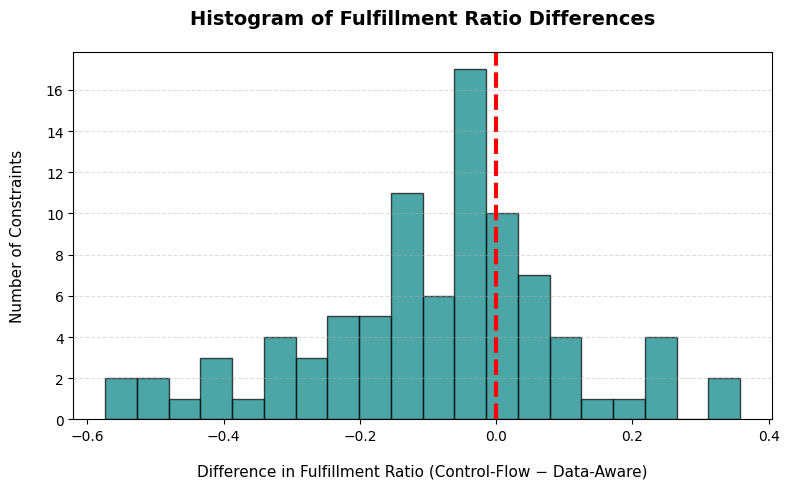

In [6]:
plot_fulfillment_diff_histogram(analyzed_df)

In [7]:
positive_df = analyzed_df[analyzed_df['diff'] > 0]

first_last = (
    positive_df
    .sort_values(by='diff')  # Sort by 'diff' first
    .groupby('Constraint', group_keys=False)
    .apply(lambda grp: grp.iloc[[0, -1]])  # Take lowest and highest 'diff' per Constraint
    .sort_values('diff', ascending=False)
)

first_last


/var/folders/1y/h0dyw5kj4yb01hwy9hy48wlm0000gn/T/ipykernel_11858/52396958.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.iloc[[0, -1]])  # Take lowest and highest 'diff' per Constraint


,Constraint,Data Condition,# Activations No Data,Fulfilment Ratio No Data,# Activations Data,Fulfilment Ratio Data,diff
65,"Not Response[CRP, IV Liquid]",CRP <= 219.55,494,0.812,141,0.454,0.358
65,"Not Response[CRP, IV Liquid]",CRP <= 219.55,494,0.812,141,0.454,0.358
60,"Not Responded Existence[CRP, IV Liquid]",CRP <= 176.64,505,0.808,136,0.456,0.352
60,"Not Responded Existence[CRP, IV Liquid]",CRP <= 176.64,505,0.808,136,0.456,0.352
59,"Not Responded Existence[CRP, ER Sepsis Triage]",CRP <= 219.55 and CRP > 121.73,2093,0.928,310,0.668,0.260
59,"Not Responded Existence[CRP, ER Sepsis Triage]",CRP <= 219.55 and CRP > 121.73,2093,0.928,310,0.668,0.260
67,"Not Response[LacticAcid, ER Sepsis Triage]",LacticAcid > 3.39,1260,0.902,51,0.647,0.255
67,"Not Response[LacticAcid, ER Sepsis Triage]",LacticAcid > 3.39,1260,0.902,51,0.647,0.255
68,"Not Response[Leucocytes, IV Liquid]",Leucocytes > 36.53,913,0.777,13,0.538,0.239
68,"Not Response[Leucocytes, IV Liquid]",Leucocytes > 36.53,913,0.777,13,0.538,0.239


In [8]:
analyzed_df[analyzed_df['diff'] < 0].sort_values('diff')

,Constraint,Data Condition,# Activations No Data,Fulfilment Ratio No Data,# Activations Data,Fulfilment Ratio Data,diff
79,"Responded Existence[Admission NC, LacticAcid]",org_group == 'G',970,0.102,34,0.676,-0.574
81,"Responded Existence[CRP, IV Liquid]",CRP > 176.64,505,0.192,36,0.750,-0.558
84,"Response[Admission NC, LacticAcid]",org_group != 'F',970,0.102,140,0.614,-0.512
50,"Not Precedence[CRP, IV Liquid]",org_group == 'L',164,0.402,10,0.900,-0.498
86,"Response[CRP, IV Liquid]",CRP > 176.64,776,0.200,58,0.655,-0.455
33,"Not Alternate Precedence[Leucocytes, IV Liquid]",org_group == 'L',172,0.384,10,0.800,-0.416
83,"Responded Existence[Leucocytes, IV Liquid]",Leucocytes <= 36.53 and Leucocytes > 4.02 and ...,2050,0.216,305,0.616,-0.400
88,"Response[Leucocytes, IV Liquid]",Leucocytes <= 36.53 and Leucocytes > 7.14 and ...,2050,0.216,206,0.607,-0.391
82,"Responded Existence[IV Antibiotics, LacticAcid]",org_group != 'L',415,0.272,174,0.626,-0.354
87,"Response[IV Antibiotics, LacticAcid]",org_group == 'A',487,0.279,213,0.615,-0.336


---
# _**Lossy Counting - With apriori support 0.6**_
---

In [9]:
analyzed_df, not_analyzed_df = analyze_sepsis_constraints(load_fulfillment_results_dataframe(list_result_files()[1]))

Loading file: sepsis_0.6_lossy.jsonl
Total constraints discovered: 56
Constraints with higher fulfilment under No Data: 17
Constraints with higher fulfilment under Data: 39
Ties (equal fulfilment): 0

Descriptive statistics for diff (No Data - Data):
count    56.000000
mean     -0.076786
std       0.169130
min      -0.487000
25%      -0.149000
50%      -0.067500
75%       0.030750
max       0.308000
Name: diff, dtype: float64


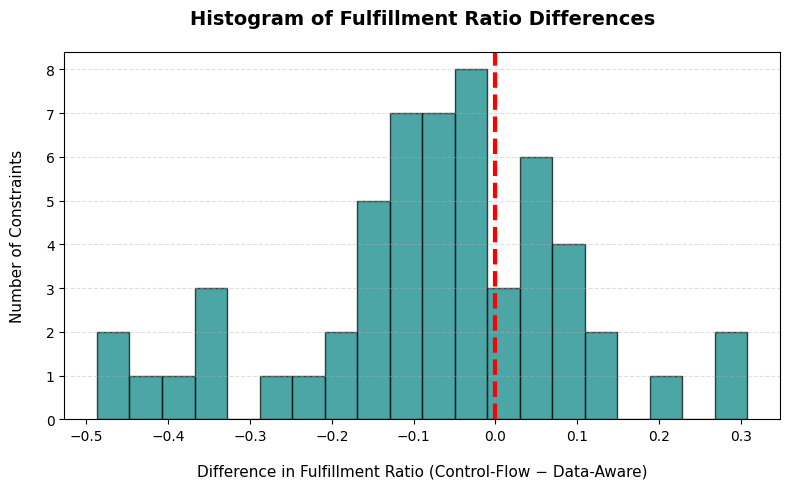

In [10]:
plot_fulfillment_diff_histogram(analyzed_df)

In [11]:
positive_df = analyzed_df[analyzed_df['diff'] > 0]

first_last = positive_df \
      .groupby('Constraint', group_keys=False)\
      .apply(lambda grp: grp.iloc[[0, -1]]) \
    .sort_values('diff', ascending=False)

first_last

/var/folders/1y/h0dyw5kj4yb01hwy9hy48wlm0000gn/T/ipykernel_11858/2556595993.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.iloc[[0, -1]]) \


,Constraint,Data Condition,# Activations No Data,Fulfilment Ratio No Data,# Activations Data,Fulfilment Ratio Data,diff
38,"Not Responded Existence[LacticAcid, ER Sepsis ...",LacticAcid > 3.94,1237,0.901,27,0.593,0.308
38,"Not Responded Existence[LacticAcid, ER Sepsis ...",LacticAcid > 3.94,1237,0.901,27,0.593,0.308
40,"Not Response[LacticAcid, ER Sepsis Triage]",LacticAcid > 1.42,1262,0.903,133,0.617,0.286
40,"Not Response[LacticAcid, ER Sepsis Triage]",LacticAcid > 1.42,1262,0.903,133,0.617,0.286
39,"Not Response[CRP, ER Sepsis Triage]",CRP <= 219.55 and CRP > 121.73,1790,0.930,113,0.726,0.204
39,"Not Response[CRP, ER Sepsis Triage]",CRP <= 219.55 and CRP > 121.73,1790,0.930,113,0.726,0.204
37,"Not Responded Existence[IV Antibiotics, Lactic...",org_group != 'A',604,0.717,17,0.588,0.129
37,"Not Responded Existence[IV Antibiotics, Lactic...",org_group != 'A',604,0.717,17,0.588,0.129
28,"Not Alternate Response[Leucocytes, LacticAcid]",Leucocytes <= 36.31 and Leucocytes <= 3.53,2079,0.658,889,0.543,0.115
28,"Not Alternate Response[Leucocytes, LacticAcid]",Leucocytes <= 36.31 and Leucocytes <= 3.53,2079,0.658,889,0.543,0.115


In [12]:
analyzed_df[analyzed_df['diff'] < 0].sort_values('diff')

,Constraint,Data Condition,# Activations No Data,Fulfilment Ratio No Data,# Activations Data,Fulfilment Ratio Data,diff
51,"Responded Existence[Leucocytes, IV Liquid]",Leucocytes > 19.95,666,0.197,38,0.684,-0.487
55,"Response[Leucocytes, IV Liquid]",Leucocytes > 19.95,642,0.198,37,0.676,-0.478
53,"Response[CRP, IV Liquid]",CRP > 281.36,569,0.162,17,0.588,-0.426
49,"Responded Existence[CRP, IV Liquid]",CRP > 281.36,566,0.159,16,0.562,-0.403
52,"Response[CRP, ER Sepsis Triage]",CRP > 219.55,1879,0.070,80,0.425,-0.355
50,"Responded Existence[IV Antibiotics, LacticAcid]",org_group == 'A',574,0.279,244,0.627,-0.348
54,"Response[IV Antibiotics, LacticAcid]",org_group == 'A',471,0.268,199,0.608,-0.340
12,"Chain Response[Admission NC, Leucocytes]",org_group != 'F' and org_group == 'T',760,0.291,51,0.549,-0.258
23,"Not Alternate Response[LacticAcid, Admission NC]",LacticAcid > 3.81,345,0.472,27,0.704,-0.232
7,"Alternate Response[LacticAcid, IV Antibiotics]",LacticAcid <= 3.81 and LacticAcid > 1.16 and L...,1253,0.458,510,0.645,-0.187
